<a href="https://colab.research.google.com/github/andoanminhkhanh/trituenhantao/blob/main/AI_mobilenet_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D
from keras.applications import MobileNet
from tensorflow.keras.layers import Flatten,Dense,Dropout
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os

Xác định kích thước đầu vào

In [5]:
batch_size = 32 # sử dụng 32 mẫu trong mỗi lần huấn luyện
img_height = 150 # chiều cao ảnh
img_width = 150 # chiều rộng ảnh

Tiền xử lý dữ liệu

In [13]:
from imutils import paths
imgTrain = list(paths.list_images("/content/drive/MyDrive/AI/data/train"))
imgVal = list(paths.list_images("/content/drive/MyDrive/AI/data/val"))

In [14]:
X_train = []
y_train = []

In [15]:
for path_train in imgTrain:

	Y_train = path_train.split(os.path.sep)[-2]

	# Xu ly anh
	img = cv2.imread(path_train)
	img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
	img = cv2.resize(img, (150, 150))

	# Them vao du lieu data va label
	X_train.append(img)
	y_train.append(Y_train)

In [16]:
# Check if any labels were extracted
print("Number of labels:", len(y_train))
if len(y_train) == 0:
    print("Warning: No labels were extracted. Check your image paths and label extraction logic.")

Number of labels: 2066


In [17]:
from sklearn.preprocessing import LabelBinarizer

X_train = np.array(X_train)
y_train = np.array(y_train)
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
X_train = X_train.astype('float32') / 255

TEST

In [18]:
X_val = []
y_val = []

In [19]:
for path_test in imgVal:

	Y_test = path_test.split(os.path.sep)[-2]

	# Xu ly anh
	img1 = cv2.imread(path_test)
	img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
	img1 = cv2.resize(img1, (150, 150))

	# Them vao du lieu data va label
	X_val.append(img1)
	y_val.append(Y_test)

In [20]:
X_val = np.array(X_val)
y_val = np.array(y_val)
y_val = lb.fit_transform(y_val)
X_val = X_val.astype('float32') / 255

Xây dựng mô hình

In [21]:
baseModel = MobileNet(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

17225924/17225924 [==============================] - 0s 0us/step


In [22]:
for layer in baseModel.layers:
	layer.trainable = False

In [23]:
model.compile(optimizer = 'adam', # phương pháp tối ưu hóa Adam
                     loss = 'sparse_categorical_crossentropy', # hàm mất mát đo sự khác biệt giữa đầu ra dự đoán và nhãn thực tế;
                     # sparse categorical cross-entropy thích hợp khi nhãn đầu vào không được mã hóa theo one-hot encoding, mà là các giá trị số nguyên
                     metrics = ['accuracy']) # các độ đo để đánh giá hiệu suất của mô hình. Độ chính xác ('accuracy') là tỷ lệ giữa số dự đoán đúng và tổng số mẫu

In [24]:
# Kiến trúc mô hình
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 75, 75, 32)        864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 75, 75, 32)        128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 75, 75, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 75, 75, 32)        288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 75, 75, 32)        128   

In [25]:
# Huấn luyện mô hình
epochs3 = 15
history3 = model.fit(
  X_train, y_train,
  validation_data = (X_val, y_val),
  epochs = epochs3,
  batch_size = 32)

Epoch 1/15
65/65 [==============================] - 54s 789ms/step - loss: 1.0277 - accuracy: 0.8717 - val_loss: 0.1728 - val_accuracy: 0.9524
Epoch 2/15
65/65 [==============================] - 51s 782ms/step - loss: 0.2126 - accuracy: 0.9201 - val_loss: 0.1279 - val_accuracy: 0.9542
Epoch 3/15
65/65 [==============================] - 49s 765ms/step - loss: 0.1362 - accuracy: 0.9439 - val_loss: 0.1653 - val_accuracy: 0.9414
Epoch 4/15
65/65 [==============================] - 49s 764ms/step - loss: 0.1353 - accuracy: 0.9463 - val_loss: 0.1397 - val_accuracy: 0.9542
Epoch 5/15
65/65 [==============================] - 47s 727ms/step - loss: 0.1009 - accuracy: 0.9661 - val_loss: 0.1258 - val_accuracy: 0.9579
Epoch 6/15
65/65 [==============================] - 48s 749ms/step - loss: 0.0942 - accuracy: 0.9627 - val_loss: 0.1305 - val_accuracy: 0.9615
Epoch 7/15
65/65 [==============================] - 46s 712ms/step - loss: 0.0733 - accuracy: 0.9714 - val_loss: 0.1254 - val_accuracy: 0.9542

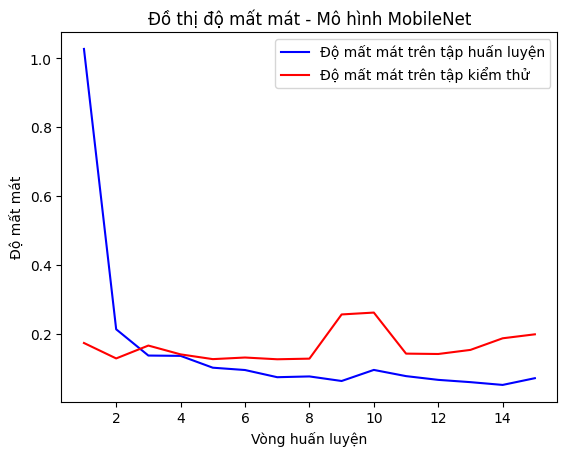

In [26]:
# Đồ thị hàm mất mát
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']
epochs = range(1, len(loss3)+1)
plt.plot(epochs, loss3, 'b', label = 'Độ mất mát trên tập huấn luyện')
plt.plot(epochs, val_loss3, 'r', label = 'Độ mất mát trên tập kiểm thử')
plt.title('Đồ thị độ mất mát - Mô hình MobileNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ mất mát')
plt.legend()
plt.show()

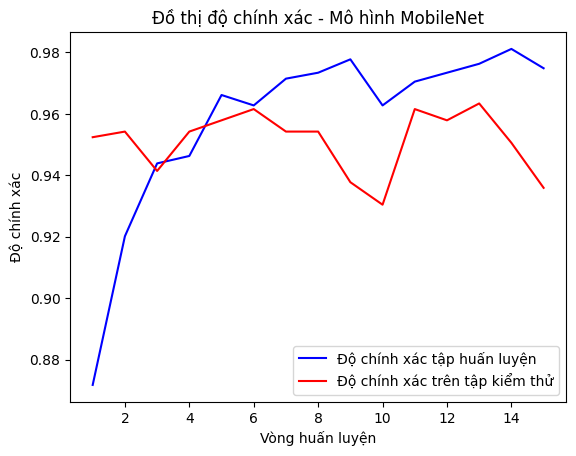

In [27]:
# Đồ thị độ chính xác của mô hình
acc3 = history3.history['accuracy']
val_acc3 = history3.history['val_accuracy']
plt.plot(epochs, acc3, 'b', label = 'Độ chính xác tập huấn luyện')
plt.plot(epochs, val_acc3, 'r', label = 'Độ chính xác trên tập kiểm thử')
plt.title('Đồ thị độ chính xác - Mô hình MobileNet')
plt.xlabel('Vòng huấn luyện')
plt.ylabel('Độ chính xác')
plt.legend()
plt.show()

In [28]:
model.save('/content/drive/MyDrive/AI/Mô hình/Moblienet 1')